In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [2]:
%matplotlib inline

# Import and clean data

In [3]:
df_clean = pd.read_csv('df_clean.csv',index_col=0 )

In [4]:
df_clean.drop(['timestamp_interaction', 'timestamp_article','sessionId'], inplace=True, axis=1)

In [5]:
# get the personal ID with more than 5 interactions.(interact with 5 unique articles)
users_interactions_count_df = df_clean.groupby(['personId', 'contentId']).size().groupby('personId').size()
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1139


In [6]:
# get the whole dataframe with users with more than 5 interactions.
interactions_from_selected_users_df = df_clean.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 55046


In [7]:
interactions_from_selected_users_df.head(3)

eventType            contentId       authorPersonId  \
0  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  CONTENT REMOVED -6451309518266745024  4340306774493623681   
2   CONTENT SHARED  4119190424078847945  4340306774493623681   

                                               title  \
0  Ethereum, a Virtual Currency, Enables Transact...   
1  Ethereum, a Virtual Currency, Enables Transact...   
2  Blockchain Technology Could Put Bank Auditors ...   

                                                text lang  \
0  All of this work is still very early. The firs...   en   
1  All of this work is still very early. The firs...   en   
2  When most people think about computers and rob...   en   

              personId                                          userAgent  \
0  4340306774493623681  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...   
1  4340306774493623681  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...   
2  4340306774493623681  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...   

  userRegion userCountry  eventStrength datetime_interaction  \
0         SP          BR            1.0  2016-03-28 15:19:39   
1         SP          BR            1.0  2016-03-28 15:19:39   
2         SP          BR            1.0  2016-03-28 15:49:59   

      datetime_article  
0  2016-03-28 15:16:01  
1  2016-03-28 15:17:47  
2  2016-04-15 14:09:23

## Convert the differenct interaction type to socres

In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [8]:
def smooth_user_preference(x):
    return math.log(x+1)

In [9]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum().apply(smooth_user_preference).reset_index()

In [10]:
interactions_full_df.shape

(38652, 3)

In [11]:
interactions_full_df.head(15)

personId            contentId  eventStrength
0  -9223121837663643404 -8949113594875411859       0.693147
1  -9223121837663643404 -8377626164558006982       0.693147
2  -9223121837663643404 -8208801367848627943       0.693147
3  -9223121837663643404 -8187220755213888616       0.693147
4  -9223121837663643404 -7423191370472335463       2.197225
5  -9223121837663643404 -7331393944609614247       0.693147
6  -9223121837663643404 -6872546942144599345       0.693147
7  -9223121837663643404 -6728844082024523434       0.693147
8  -9223121837663643404 -6590819806697898649       0.693147
9  -9223121837663643404 -6558712014192834002       0.693147
10 -9223121837663643404 -6545872007932025533       1.098612
11 -9223121837663643404 -6484638837208285334       0.693147
12 -9223121837663643404 -5781461435447152359       0.693147
13 -9223121837663643404 -5002383425685129595       0.693147
14 -9223121837663643404 -4541461982704074404       0.693147

## partition the data into train and test set

In [12]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

## Evaluation

We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set. The Top-N accuracy metric choosen was Recall@N which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [13]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [14]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [192]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(interactions_from_selected_users_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)
        
        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    # catalog coverage
    def item_coverage(self, model):
        recs = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df))
                                                   
            for i in list(person_recs_df.contentId):  
                if  i not in recs:
                    recs.append(i)
        
        iC = len(recs)/len(interactions_full_df.contentId.unique())
        return iC

In [193]:
model_evaluator = ModelEvaluator() 

## User-user based recommender

In [115]:
P = np.zeros((utility.shape[0],utility.shape[0]))
for i in range(utility.shape[0]):
    if sum(utility.iloc[i,:])!=0:
        P[i][i] = 1/sum(utility.iloc[i,:]**2)
    else: P[i][i] = 0

In [116]:
user_user = np.sqrt(P).dot(utility_matrix).dot(utility_matrix.T).dot(np.sqrt(P)).dot(utility_matrix)

In [117]:
user_preds_df = pd.DataFrame(user_user, columns = utility.columns, index=users_ids).transpose()
user_preds_df.head(10)

-9223121837663643404  -9212075797126931087  \
contentId                                                          
-9222795471790223670              0.354986              0.000000   
-9194572880052200111              0.320328              0.014573   
-9192549002213406534              0.939465              0.094134   
-9190737901804729417              0.163550              0.000000   
-9189659052158407108              0.652079              0.343753   
-9184137057748005562              0.013049              0.000000   
-9176143510534135851              0.448222              0.064256   
-9172673334835262304              0.036495              0.000000   
-9171475473795142532              0.182067              0.000000   
-9166778629773133902              0.141482              0.023098   

                      -9207251133131336884  -9199575329909162940  \
contentId                                                          
-9222795471790223670              0.000000              0.249470   
-9194572880052200111              0.201097              0.031751   
-9192549002213406534              0.584787              0.103947   
-9190737901804729417              0.000000              0.075742   
-9189659052158407108              0.760906              0.096814   
-9184137057748005562              0.000000              0.000000   
-9176143510534135851              0.676019              0.465821   
-9172673334835262304              0.000000              0.000000   
-9171475473795142532              0.000000              0.034932   
-9166778629773133902              0.000000              0.000000   

                      -9196668942822132778  -9188188261933657343  \
contentId                                                          
-9222795471790223670              0.000000              0.023879   
-9194572880052200111              0.717018              0.049690   
-9192549002213406534              0.290629              0.610392   
-9190737901804729417              0.000000              0.000000   
-9189659052158407108              0.476254              0.153943   
-9184137057748005562              0.000000              0.000000   
-9176143510534135851              0.050720              0.029540   
-9172673334835262304              0.011870              0.028925   
-9171475473795142532              0.018788              0.000000   
-9166778629773133902              0.040531              0.046385   

                      -9172914609055320039  -9156344805277471150  \
contentId                                                          
-9222795471790223670              0.148642              0.096912   
-9194572880052200111              0.123616              0.265825   
-9192549002213406534              0.509305              0.464758   
-9190737901804729417              0.028995              0.000000   
-9189659052158407108              0.274536              0.275332   
-9184137057748005562              0.010830              0.010648   
-9176143510534135851              0.235007              0.218369   
-9172673334835262304              0.016897              0.008307   
-9171475473795142532              0.053490              0.000000   
-9166778629773133902              0.067896              0.076049   

                      -9120685872592674274  -9109785559521267180  \
contentId                                                          
-9222795471790223670              0.083995              0.118644   
-9194572880052200111              0.239837              0.142322   
-9192549002213406534              0.583265              0.541935   
-9190737901804729417              0.000000              0.027056   
-9189659052158407108              0.448919              0.315980   
-9184137057748005562              0.015946              0.086905   
-9176143510534135851              0.275296              0.474390   
-9172673334835262304              0.024880              0.044596   
-9171475473795142532              0.000000              0.092606   
-91667

In [118]:
user_recommender_model = ItemRecommender(user_preds_df)

## content based model

In [250]:
articles_df = df_clean.drop_duplicates('text')

#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=10000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2941x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 738976 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.

In [251]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [252]:
user_profiles = build_users_profiles()

In [253]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [254]:
content_based_recommender_model = ContentBasedRecommender(articles_df)

## Hybrid Model - Linear Combination

In [129]:
class HybridRecommenderLinear:
    
    
    MODEL_NAME = 'Hybrid_Linear'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, lamba):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        self.lamba = lamba
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = self.lamba *recs_df['recStrengthCB'] + (1-self.lamba)* recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

### Grid Search 

In [204]:
k = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
hybrid_linear_scores = {}

for lamba in k:
    hybrid_recommender_model_linear = HybridRecommenderLinear(content_based_recommender_model, user_recommender_model, articles_df,lamba)
    svd_global_metrics, svd_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model_linear)
    item_coverage = model_evaluator.item_coverage(hybrid_recommender_model_linear)
    svd_global_metrics['Item Coverage'] = item_coverage
    hybrid_linear_scores[lamba] = svd_global_metrics

1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed


In [206]:
hybrid_linear_scores = pd.DataFrame(hybrid_linear_scores).T
hybrid_linear_scores = hybrid_linear_scores.drop(columns = ['modelName'])

In [228]:
hybrid_linear_scores = hybrid_linear_scores[['recall@5', 'recall@10','Item Coverage']]

Text(0, 0.5, 'Accuracy')

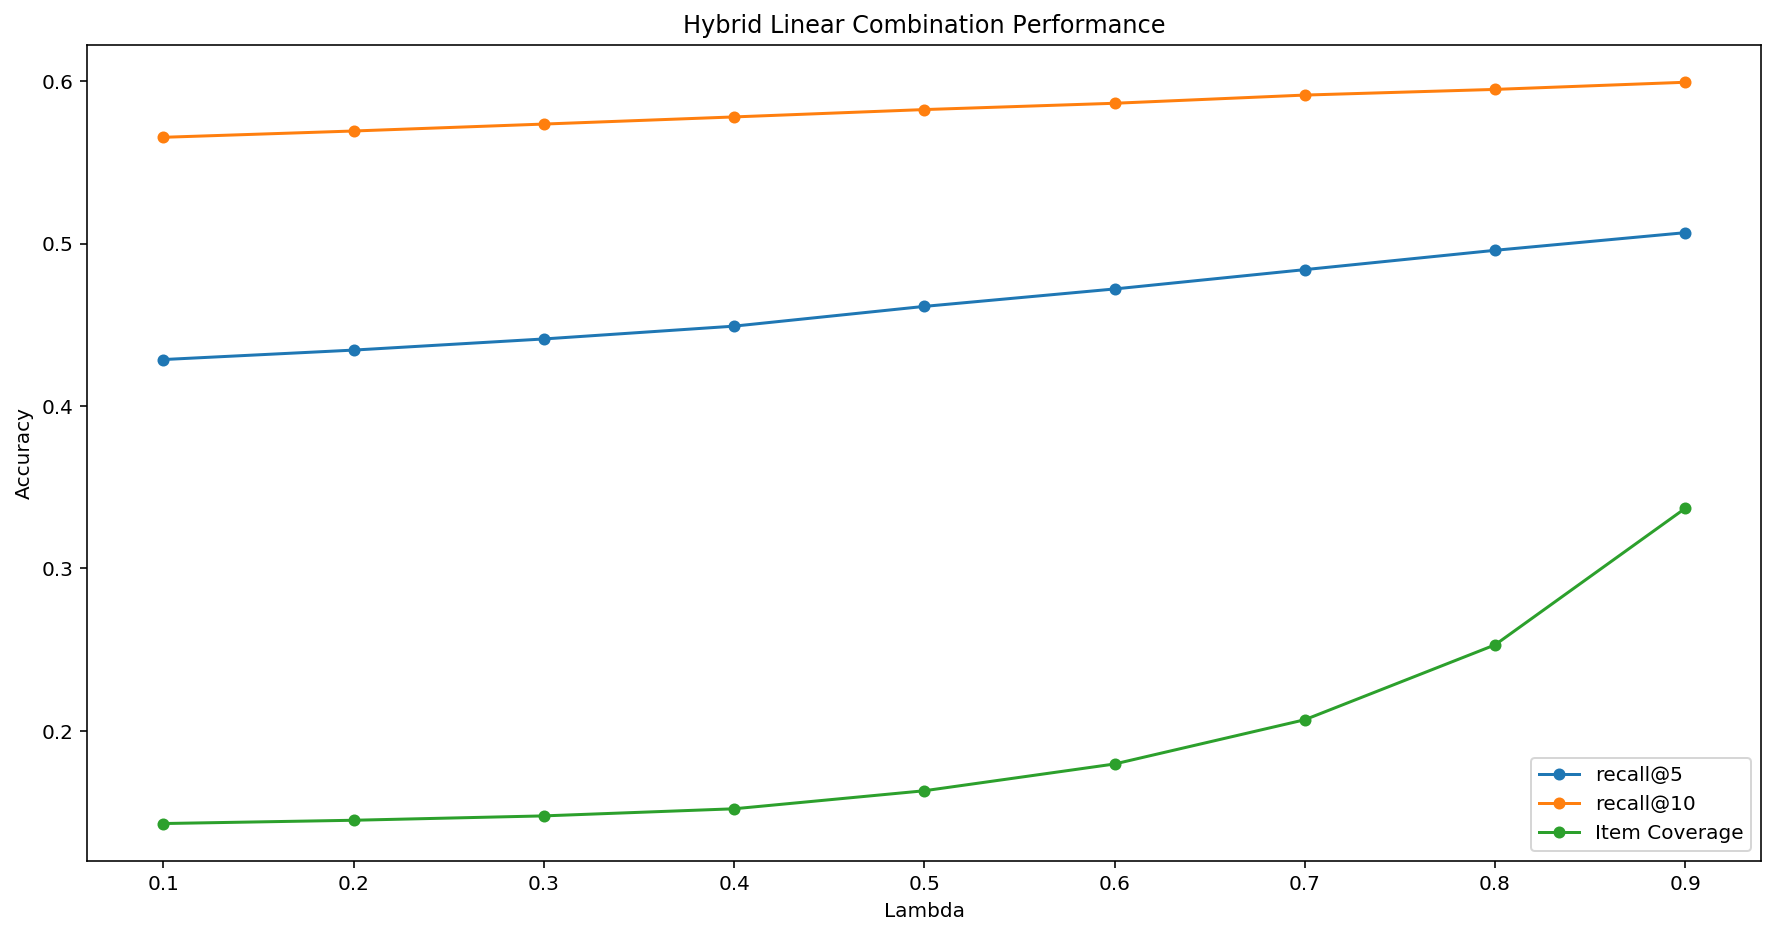

In [275]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import seaborn as sns


import geopandas, fiona
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point
from functools import partial

import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 7.5)

from datetime import datetime
import re


hybrid_linear_plot = hybrid_linear_scores.plot.line( ms=10, marker='.',title="Hybrid Linear Combination Performance")
hybrid_linear_plot.set_xlabel("Lambda")
hybrid_linear_plot.set_ylabel("Accuracy")


In [260]:
hybrid_linear_scores

recall@5 recall@10 Item Coverage
0.1  0.428664  0.565515      0.142953
0.2  0.434485  0.569396      0.144971
0.3   0.44134  0.573664      0.147662
0.4   0.44923  0.578062      0.152035
0.5  0.461389   0.58259      0.163135
0.6  0.472125   0.58647      0.179617
0.7  0.484025  0.591515      0.206862
0.8  0.495925  0.595007      0.252943
0.9  0.506791  0.599405      0.337033

## Hybrid - Multiplication

In [184]:
class HybridRecommenderProduct:
    
    
    MODEL_NAME = 'Hybrid_Product'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] =recs_df['recStrengthCB'] *recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [261]:
hybrid_recommender_model_production = HybridRecommenderProduct(content_based_recommender_model, user_recommender_model, articles_df)

print('Evaluating Popularity recommendation model...')
product_svd_global_metrics, product_svd_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model_production)
print('\nGlobal metrics:\n%s' % product_svd_global_metrics)
product_catalog_coverage = model_evaluator.item_coverage(hybrid_recommender_model_production)
print('\nItem Coverage:\n%s' % product_catalog_coverage)

Evaluating Popularity recommendation model...
1138 users processed

Global metrics:
{'modelName': 'Hybrid_Product', 'recall@5': 0.49062217048247314, 'recall@10': 0.5922907773897297}

Item Coverage:
0.22872519340733266


## Hybrid - Mixed

In [188]:
class HybridRecommenderMixed:
    
    
    MODEL_NAME = 'Hybrid_Mixed'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df.apply(lambda x : x['recStrengthCB'] if x['recStrengthCB'] >= x['recStrengthCF']  else  x['recStrengthCF'], axis=1)

        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [262]:
hybrid_recommender_model_mixed= HybridRecommenderMixed(content_based_recommender_model, user_recommender_model, articles_df)

print('Evaluating Popularity recommendation model...')
mixed_svd_global_metrics, mixed_svd_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model_mixed)
print('\nGlobal metrics:\n%s' % mixed_svd_global_metrics)
mixed_catalog_coverage = model_evaluator.item_coverage(hybrid_recommender_model_mixed)
print('\nItem Coverage:\n%s' % mixed_catalog_coverage)

Evaluating Popularity recommendation model...
1138 users processed

Global metrics:
{'modelName': 'Hybrid_Mixed', 'recall@5': 0.4321562540421679, 'recall@10': 0.5683611434484542}

Item Coverage:
0.14732593340060546
